# THIS NOTEBOOK IS DEPRECATED AND USELESS

In [1]:

using Catalyst
using DifferentialEquations
using Plots
using Zygote
using SciMLSensitivity
using Optimization
using OptimizationOptimisers
using ForwardDiff

# fc = fully connected
# rt = ring topology

function get_fc_species_list(n::Int64)::Vector{Vector{String}}
    """
    Given integer `n`, return a length-sorted Vector{Vector{String}} object in which
    Vector{String} objects are all ways of listing a non-empty subset of the `n` 
    monomers in a fully connected reaction network topology, up to permutation.
    Each monomer is represented by a string of the form `Xi`.
    """
    monomers = ["X$i" for i in 1:n]
    species_list = []

    for i in 1:(2 ^ n - 1)
        # `inclusion` uses binary encodings to iterate through non-empty elements
        # of the power set of the set of monomers.
        inclusion = digits(i, base=2, pad=n)
        addend_species = [monomers[i] for i in 1:n if inclusion[i] == 1]
        sort!(addend_species, by=x->parse(Int, x[2:end]))
        species_list = [species_list; [addend_species]]
    end

    sort!(species_list, by=x->length(x))
    return species_list
end

function get_species_string(species_list::Vector{Vector{String}})::String
    """
    Given Vector{Vector{String}} `species_list`, return a String to be evaluated
    as code that lists all species as functions of time for Catalyst.jl's `@species`
    macro. 
    """
    # Convert Vector{String} objects that represent species into Strings
    species_string_list = [join(species) for species in species_list]
    # Prepend macros
    eval_string_line1 = "@variables t; "
    eval_string_line2 = "@species " * join(species_string_list, "(t) ") * "(t)"

    return eval_string_line1 * eval_string_line2
end

function convert_vec_to_string(vec::Vector{String})::String
    """
    Given a Vector object `vec`, return a String representation of it. E.g. given
    a vector containing "X1" and "X2", return String "[X1, X2]".
    """
    return "[" * join(vec, ", ") * "]"
end

function get_fc_rxs_eval_string(species_list::Vector{Vector{String}})::String
    """
    Given a Vector{Vector{String}} `species_list`, return a String to be evaluated
    as code that lists all reactions in a fully connected reaction network topology.
    """
    # In the fully connected topology, the number of species is 2 ^ n - 1.
    num_monomers = Int(log2(length(species_list) + 1))
    # Remove the end product from species_list
    sort!(species_list, by=x->length(x))
    pop!(species_list)

    monomers = [monomer[1] for monomer in species_list[1:num_monomers]]

    rxs_eval_string = "rxs = ["
    # reactant is a vector of bound monomers
    for reactant in species_list
        k_index = length(reactant) * 2 - 1
        # monomer is a singleton vector containing a monomer
        for monomer in monomers
            # Don't record reactions in which either (1) a complex containing itself
            # or (2) the reaction between monomers has already been recorded, just
            # in the other order of reactants.
            if monomer in reactant ||
                (length(reactant) == 1 && Int(monomer[2]) < Int(reactant[1][2]))
                continue
            end

            reactants = [join(reactant), monomer]
            product_string = join(sort([reactant; monomer], by=x->parse(Int, x[2:end])))
            product_string = "[" * product_string * "]"
            reactants_string = convert_vec_to_string(reactants)
            # Add forward direction of the reaction
            rxs_eval_string *= "Reaction(k[$(k_index)], $(reactants_string), $(product_string)), "
            # Add reverse direction of the reaction
            rxs_eval_string *= "Reaction(k[$(k_index+1)], $(product_string), $(reactants_string)), "
        end
    end

    # Prepend macro that specifies the parameters, which we store in the Vector{Float64}
    # `k`
    num_params = (num_monomers - 1) * 2
    eval_string_line1 = "@parameters k[1:$(num_params)]; "
    # Append closing bracket to Vector{Reaction} object
    eval_string_line2 = rxs_eval_string * "]"

    return eval_string_line1 * eval_string_line2
end

function get_rate_constants_from_k_ons(k_ons::Vector,
                                       topology::String;
                                       delta_G_kb_T::Float64=-20., 
                                       C0::Float64=1e4)::Vector{Float64}
    """
    Given binding reaction rates `k_ons`, return a Vector of alternating k_on and
    corresponding k_off values, according to eq. 2 in the preprint.
    """
    rates = []
    for (i, k_on) in enumerate(k_ons)
        if topology == "fc"
            m = i
        elseif topology == "rt"
            m = min(2, i)
        else
            # In the ring topology, 
            error("Topology must be 'fc' or 'rt'")
        end
        rates = [rates; [k_on, k_on * C0 * exp(m * delta_G_kb_T)]]
    end
    
    return rates
end

function get_fc_rn(n::Int64)::ReactionSystem
    """
    Given integer `n`, return a ReactionSystem object representing a fully connected
    rate growth chemical reaction network.
    """
    species_list = get_fc_species_list(n)

    # Evaluate meta-programmed strings describing the species and reactions involved
    # in the network.
    species_eval_string = get_species_string(species_list)
    eval(Meta.parse(species_eval_string))
    rxs_eval_string = get_fc_rxs_eval_string(species_list)
    eval(Meta.parse(rxs_eval_string))

    @named rn = ReactionSystem(rxs, t)
    return rn
end

function sample_rn(rn::ReactionSystem,
                   topology::String,
                   k_ons::Vector,
                   t_span::Tuple;
                   num_samples::Int64=100,
                   noise::Float64=0.1)::Tuple{Vector, Array, ODEProblem}
    # Start with concentration 1 for all monomers, whose names have 5 characters,
    # e.g. "X1(t)"
    u0 = [length(string(species)) == 5 for species in species(rn)]
    # The time span should start from a small, but non-zero time in order to avoid 
    # taking the log of zero.
    # Obtain a log10-spaced vector of times at which to sample the ODE solution.
    # The log10-scale enables us to observe trapping at early simulation times.
    sample_times = 10 .^ range(log10(t_span[1]), log10(t_span[2]), length=num_samples)

    params = get_rate_constants_from_k_ons(k_ons, topology)
    prob = ODEProblem(rn, u0, t_span, params)
    sol_real = solve(prob, Tsit5(); tstops = sample_times)
    sample_vals = Array(sol_real(sample_times))

    # Add noise to the ODE solution by uniformly sampling a coefficient for the
    # observed value at each time step from the interval [1-`noise`/2, 1+`noise`/2].
    sample_vals .*= (1 .+ noise * rand(Float64, size(sample_vals)) .- (noise / 2))

    return sample_times, sample_vals, prob
end

function optimise_p(p_init::Vector, 
                    topology::String,
                    t_span::Tuple,
                    sample_times::Vector{Float64}, 
                    sample_vals::Array{Float64, 2}, 
                    prob::ODEProblem)::Vector{Float64}
    println(p_init)
    """
    `topology` should be "fc" for fully connected topology or "rg" for ring topology
    """
    function loss(p, _)
        newtimes = filter(<=(t_span[2]), sample_times)
        params = get_rate_constants_from_k_ons(p, topology)
        newprob = remake(prob; tspan=t_span, p=params)
        sol = Array(solve(newprob, TRBDF2(); saveat = newtimes))

        loss = sum(abs2, sol[7, :] .- sample_vals[7, 1:size(sol,2)])
        return loss, sol
    end

    # optimize for the parameters that minimize the loss
    optf = OptimizationFunction(loss, Optimization.AutoZygote())
    optprob = OptimizationProblem(optf, p_init)
    sol = solve(optprob, OptimizationOptimisers.ADAM(10); maxiters = 200)

    # Return the parameter estimates
    return sol.u
end

# Load reaction network and get sample to be fit to
rn = get_fc_rn(3)

Model rn
States (7):
  X1(t)
  X2(t)
  X1X2(t)
  X3(t)
⋮
Parameters (4):
  k[1]
  k[2]
  k[3]
  k[4]

In [18]:
trimer = @reaction_network begin
    (k_dim_on, k_dim_off), X + Y <--> XY
    (k_dim_on, k_dim_off), X + Z <--> XZ
    (k_dim_on, k_dim_off), Y + Z <--> YZ
    (k_tri_on, k_tri_off), XY + Z <--> XYZ
    (k_tri_on, k_tri_off), XZ + Y <--> XYZ
    (k_tri_on, k_tri_off), YZ + X <--> XYZ
end

Model ##ReactionSystem#304
States (7):
  X(t)
  Y(t)
  XY(t)
  Z(t)
⋮
Parameters (4):
  k_dim_on
  k_dim_off
  k_tri_on
  k_tri_off

In [29]:
convert(ODESystem, get_fc_rn(2))

Model rn with 3 equations
States (3):
  X1(t)
  X2(t)
  X1X2(t)
Parameters (2):
  k[1]
  k[2]

In [2]:
using Latexify

In [3]:
x = 5
latexify(x)

L"$5$"

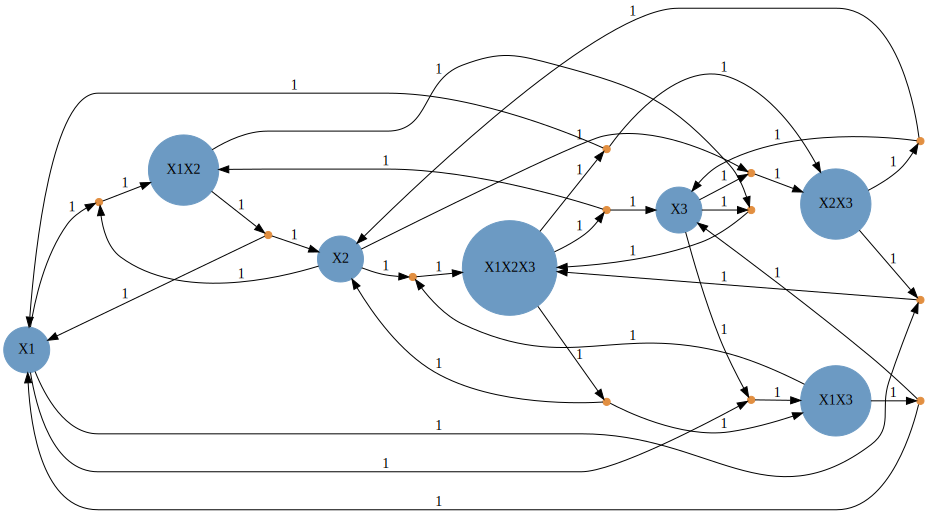

In [2]:
g = Graph(rn)